# Телекоммуникации

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Наша задача — обучить на этих данных модель для прогноза оттока клиентов.

**Описание услуг:**

Оператор предоставляет два основных типа услуг: 
* Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
* Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:
* Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
* Выделенная линия технической поддержки (TechSupport);
* Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
* Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).
* Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.

**Описание данных:**

Данные состоят из нескольких файлов, полученных из разных источников:
* contract_new.csv — информация о договоре;
* personal_new.csv — персональные данные клиента;
* internet_new.csv — информация об интернет-услугах;
* phone_new.csv — информация об услугах телефонии.

Файл contract_new.csv:
* customerID — идентификатор абонента;
* BeginDate — дата начала действия договора;
* EndDate — дата окончания действия договора, **на основе этого признака мы сгенерируем наш целевой признак (если клиент ушёл, дата проставлена)**;
* Type — тип оплаты: раз в год-два или ежемесячно;
* PaperlessBilling — электронный расчётный лист;
* PaymentMethod — тип платежа;
* MonthlyCharges — расходы за месяц;
* TotalCharges — общие расходы абонента.

Файл personal_new.csv:
* customerID — идентификатор пользователя;
* gender — пол;
* SeniorCitizen — является ли абонент пенсионером;
* Partner — есть ли у абонента супруг или супруга;
* Dependents — есть ли у абонента дети.

Файл internet_new.csv:
* customerID — идентификатор пользователя;
* InternetService — тип подключения;
* OnlineSecurity — блокировка опасных сайтов;
* OnlineBackup — облачное хранилище файлов для резервного копирования данных;
* DeviceProtection — антивирус;
* TechSupport — выделенная линия технической поддержки;
* StreamingTV — стриминговое телевидение;
* StreamingMovies — каталог фильмов.

Файл phone_new.csv:
* customerID — идентификатор пользователя;
* MultipleLines — подключение телефона к нескольким линиям одновременно.

Информация о договорах актуальна на 1 февраля 2020 года.

**План работы:**

Перед нами стоит задача бинарной классификации: нам необходимо предсказать ухода клиента – отказ от продолжения пользования услугами, предоставляемыми заказчиком.

Целевым признаком будет являться информация, хранящаяся в поле EndDate: в нём указано, окончен контракт или нет.

В качестве основной метрики для оценки качества модели будем использовать Roc-Auc.
С помощью метрики Accuracy интерпретируем работу модели (используя матрицу ошибок).

1. Загрузим данные и ознакомимся с ними.
2. Выполним предобработку данных каждого датафрейма и отберём необходимые признаки.
3. Объединим данные в один датафрейм.
4. Проведём исследовательский анализ данных, включая корреляционный анализ. При необходимости сгенерируем новые признаки.
5. Подготовим данные для обучения моделей.
6. Обучим разные модели, с подбором гиперпараметров, чтобы выбрать лучшую.
7. Проверим качество модели на тестовой выборке.
8. Сформулируем итоговые выводы.

In [1]:
# установим недостающие библиотеки и обновим необходимые
!pip install phik -q
!pip install shap -q
!pip install -U scikit-learn -q

In [2]:
# загрузим необходимые библиотеки

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import (
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler,
    LabelEncoder
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    recall_score,
    precision_score,
    roc_curve,
    confusion_matrix
)
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from catboost import CatBoostClassifier
import shap
import warnings

In [3]:
# скроем предупреждения и настроим отображение максимума столбцов в таблицах
warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)

## Загрузка данных
Загрузим данные и ознакомимся с ними.

### Информация о договорах

In [6]:
contract = pd.read_csv('/datasets/contract_new.csv')

display(contract.head(10))
contract.info()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


В датафрейме 7043 строки. Явные пропуски в данных отсутствуют. Однако, присутствуют неявные, как минимум в столбце EndDate.


Приведём названия столбцов к «змеиному регистру», а также посмотрим, где нам необходимо исправить тип данных.
* customerID — customer_id;
* BeginDate — begin_date, тип необходимо сменить на date_time;
* EndDate — end_date, тип данных необходимо будет будет сменить на datetime, воспользовавшись заглушкой для значений без даты;
* Type — type;
* PaperlessBilling — paperless_billing;
* PaymentMethod — payment_method;
* MonthlyCharges — monthly_charges;
* TotalCharges — total_charges, тип данных необходимо будет сменить на float.

In [7]:
contract_columns = ['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing', 'payment_method',
                   'monthly_charges', 'total_charges'] 

contract.columns = contract_columns

Посмотрим, как таблица выглядит теперь:

In [8]:
contract.head(3)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17


### Персональные данные

In [9]:
personal = pd.read_csv('/datasets/personal_new.csv')

display(personal.head(10))
personal.info()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


В датафрейме 7043 строки. Пропуски в данных отсутствуют.

Приведём названия столбцов к «змеиному регистру», а также посмотрим, где нам необходимо исправить тип данных.
* customerID — customer_id;
* gender — пол;
* SeniorCitizen — senior_citizen, изменим тип на bool;
* Partner — partner;
* Dependents — dependents.

In [10]:
personal_columns = ['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents']

personal.columns = personal_columns

Посмотрим, как таблица выглядит теперь:

In [11]:
personal.head(3)

,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No


### Информация об интернет-услугах

In [12]:
internet = pd.read_csv('/datasets/internet_new.csv')

display(internet.head(10))
internet.info()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


В датафрейме 5517 строки. Пропуски в данных отсутствуют. Типы данных верные.

Приведём названия столбцов к «змеиному регистру».
* customerID — customer_id;
* InternetService — internet_service;
* OnlineSecurity — online_security;
* OnlineBackup — online_backup;
* DeviceProtection — device_protection;
* TechSupport — tech_support;
* StreamingTV — streaming_tv;
* StreamingMovies — streaming_movies.

In [13]:
internet_columns = ['customer_id', 'internet_service', 'online_security', 'online_backup', 'device_protection',
                   'tech_support', 'streaming_tv', 'streaming_movies']

internet.columns = internet_columns

Посмотрим, как таблица выглядит теперь:

In [14]:
internet.head(3)

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No


### Информация о телефонии

In [15]:
phone = pd.read_csv('/datasets/phone_new.csv')

display(phone.head(10))
phone.info()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


В датафрейме 5517 строки. Пропуски в данных отсутствуют. Типы данных верные.

Приведём названия столбцов к «змеиному регистру».
* customerID — customer_id;
* MultipleLines – multiple_lines

In [16]:
phone_columns = ['customer_id', 'multiple_lines']

phone.columns = phone_columns

Посмотрим, как таблица выглядит теперь:

In [17]:
phone.head(3)

,customer_id,multiple_lines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No


### Вывод

На этом шаге мы ознакомились с данными в каждом из четырёх файлов. Для удобства дальнейшей работы мы привели названия столбцов к «змеиному регистру». Количество строк в файлах разное: в двух таблицах 7043 строки, в одной 5517 и в одной 6361. В данных нет явных пропусков, однако могут присутствовать неявные. У некоторых столбцов необходимо исправить типы данных. Сделаем это на этапе предобработки данных.

## Предобработка данных

### Информация о договорах

In [18]:
display(contract.head(5))
contract.info()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Проверим данные на наличие дубликатов:

In [19]:
contract.duplicated().sum()

0

Посмотрим на уникальные значения:

In [20]:
print(contract.nunique())
print('')

for i in contract_columns:
    print(contract[i].sort_values().unique())

customer_id          7043
begin_date             77
end_date               67
type                    3
paperless_billing       2
payment_method          4
monthly_charges      1585
total_charges        6658
dtype: int64

['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' ... '9992-UJOEL' '9993-LHIEB'
 '9995-HOTOH']
['2013-10-01' '2013-11-01' '2013-12-01' '2014-01-01' '2014-02-01'
 '2014-03-01' '2014-04-01' '2014-05-01' '2014-06-01' '2014-07-01'
 '2014-08-01' '2014-09-01' '2014-10-01' '2014-11-01' '2014-12-01'
 '2015-01-01' '2015-02-01' '2015-03-01' '2015-04-01' '2015-05-01'
 '2015-06-01' '2015-07-01' '2015-08-01' '2015-09-01' '2015-10-01'
 '2015-11-01' '2015-12-01' '2016-01-01' '2016-02-01' '2016-03-01'
 '2016-04-01' '2016-05-01' '2016-06-01' '2016-07-01' '2016-08-01'
 '2016-09-01' '2016-10-01' '2016-11-01' '2016-12-01' '2017-01-01'
 '2017-02-01' '2017-03-01' '2017-04-01' '2017-05-01' '2017-06-01'
 '2017-07-01' '2017-08-01' '2017-09-01' '2017-10-01' '2017-11-01'
 '2017-12-01' '2018-01-01' '2018-

В столбцах end_date и total_charges присутствуют неявные пропуски. В первом случае они означают, что контракт не расторгнут, во втором — что абонент ещё не успел накопить расходов. Поэтому в первом случае заменим пропуски заглушкой, равной дате следующего месяца, чем последний в наших данных, а во втором случае заменим пропуски на ноль.

Также нам необходимо изменить типы данных у столбцов с датой начала и окончания контракта, и у столбца total_charges.

In [21]:
contract['begin_date'] = pd.to_datetime(
    contract['begin_date'], format='%Y-%m-%d'
)

In [22]:
contract['end_date'] = contract['end_date'].replace('No', '2020-02-01', regex=True)
contract['end_date'] = pd.to_datetime(
    contract['end_date'], format='%Y-%m-%d'
)

In [23]:
contract['total_charges'] = contract['total_charges'].replace([' ', '0'], regex=True)
contract['total_charges'] = contract['total_charges'].astype('float')

Посмотрим, есть ли какие-то выбивающиеся значения в столбцах monthly_charges и total_charges.

In [24]:
contract.describe()

,monthly_charges,total_charges
count,7043.000000,7043.000000
mean,64.761692,2120.553699
std,30.090047,2113.656071
min,18.250000,19.050000
25%,35.500000,439.975000
50%,70.350000,1346.420000
75%,89.850000,3253.000000
max,118.750000,9221.380000


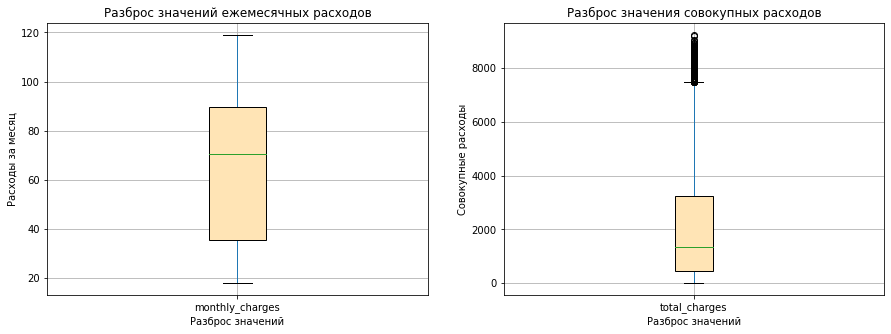

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

contract['monthly_charges'].plot(kind='box', grid='True', ax=axes[0], patch_artist=True, 
                 boxprops = dict(facecolor='moccasin'))
axes[0].set_title('Разброс значений ежемесячных расходов')
axes[0].set_xlabel('Разброс значений')
axes[0].set_ylabel('Расходы за месяц')
contract['total_charges'].plot(kind='box', grid='True', widths = 0.1, ax=axes[1], patch_artist=True, 
                 boxprops = dict(facecolor='moccasin'))
axes[1].set_title('Разброс значения совокупных расходов')
axes[1].set_xlabel('Разброс значений')
axes[1].set_ylabel('Совокупные расходы')
plt.show()

На одном из графиков наблюдаются выбросы, но но это не единичные случаи, и они вполне укладываются в редкие, но возможные значения. Так что скорее всего, не являются ошибками в знаке.

Посмотрим, как распределены значения категориальных признаков:

In [26]:
for i in ['type', 'paperless_billing', 'payment_method']:
    print(contract.groupby(i)[i].count().sort_values(ascending=False))
    print('')

type
Month-to-month    3875
Two year          1695
One year          1473
Name: type, dtype: int64

paperless_billing
Yes    4171
No     2872
Name: paperless_billing, dtype: int64

payment_method
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: payment_method, dtype: int64



В распределении присутствует дисбаланс, однако, нет такого, чтобы в каких-то группах было аномально мало или аномально много наблюдений.

Посмотрим, как выглядят наши данные теперь:

In [27]:
display(contract.head(5))
contract.info()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB


Типы данных указаны верно. Пропусков нет (помним о поставленной нами заглушке в поле end_date).

### Персональные данные

In [28]:
display(personal.head(5))
personal.info()

,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


Проверим данные на наличие дубликатов:

In [29]:
personal.duplicated().sum()

0

Посмотрим на уникальные значения:

In [30]:
print(personal.nunique())
print('')

for i in personal_columns:
    print(personal[i].sort_values().unique())

customer_id       7043
gender               2
senior_citizen       2
partner              2
dependents           2
dtype: int64

['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' ... '9992-UJOEL' '9993-LHIEB'
 '9995-HOTOH']
['Female' 'Male']
[0 1]
['No' 'Yes']
['No' 'Yes']


Пропуски явные и неявные в данных отсутствуют, дубликаты также отсутствуют. Для удобства приведём значения столбцов, содержащих бинарный признак, к единому стилю. Большинство таких признаков имеют вид Yes/No, поэтому изменим признак senior_citizen. Так значения будут красивие отображаться на графиках и они будут иметь более читабельный вид.

In [31]:
personal['senior_citizen'] = personal['senior_citizen'].replace(0, 'No', regex=True)
personal['senior_citizen'] = personal['senior_citizen'].replace(1, 'Yes', regex=True)

Посмотрим, как распределены значения категориальных признаков:

In [32]:
for i in ['gender', 'senior_citizen', 'partner', 'dependents']:
    print(personal.groupby(i)[i].count().sort_values(ascending=False))
    print('')

gender
Male      3555
Female    3488
Name: gender, dtype: int64

senior_citizen
No     5901
Yes    1142
Name: senior_citizen, dtype: int64

partner
No     3641
Yes    3402
Name: partner, dtype: int64

dependents
No     4933
Yes    2110
Name: dependents, dtype: int64



В распределении присутствует дисбаланс, однако, нет такого, чтобы в каких-то группах было аномально мало или аномально много наблюдений.

Посмотрим, как выглядят наши данные в результате проделанной предобработки.

In [33]:
display(personal.head(5))
personal.info()

,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,No,Yes,No
1,5575-GNVDE,Male,No,No,No
2,3668-QPYBK,Male,No,No,No
3,7795-CFOCW,Male,No,No,No
4,9237-HQITU,Female,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   object
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: object(5)
memory usage: 275.2+ KB


Типы данных указаны верно. Пропусков нет. Дубликаты отсутствуют. Значения бинарных признаков оформлены в едином стиле.

### Информация об интернет-услугах

In [34]:
display(internet.head(5))
internet.info()

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


Проверим данные на наличие дубликатов:

In [35]:
internet.duplicated().sum()

0

Посмотрим на уникальные значения:

In [36]:
print(internet.nunique())
print('')

for i in internet_columns:
    print(internet[i].sort_values().unique())

customer_id          5517
internet_service        2
online_security         2
online_backup           2
device_protection       2
tech_support            2
streaming_tv            2
streaming_movies        2
dtype: int64

['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' ... '9992-UJOEL' '9993-LHIEB'
 '9995-HOTOH']
['DSL' 'Fiber optic']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']


Типы данных указаны верно. Пропусков нет. Дубликаты отсутствуют. Значения бинарных признаков оформлены в едином стиле. Ошибки в данных также отсутствуют.

Посмотрим, как распределены значения категориальных признаков:

In [37]:
for i in ['internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support',
          'streaming_tv', 'streaming_movies']:
    print(internet.groupby(i)[i].count().sort_values(ascending=False))
    print('')

internet_service
Fiber optic    3096
DSL            2421
Name: internet_service, dtype: int64

online_security
No     3498
Yes    2019
Name: online_security, dtype: int64

online_backup
No     3088
Yes    2429
Name: online_backup, dtype: int64

device_protection
No     3095
Yes    2422
Name: device_protection, dtype: int64

tech_support
No     3473
Yes    2044
Name: tech_support, dtype: int64

streaming_tv
No     2810
Yes    2707
Name: streaming_tv, dtype: int64

streaming_movies
No     2785
Yes    2732
Name: streaming_movies, dtype: int64



Не наблюдается, чтобы в каких-то группах было аномально мало или аномально много наблюдений.

### Информация о телефонии

In [38]:
display(phone.head(5))
phone.info()

,customer_id,multiple_lines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Проверим данные на наличие дубликатов:

In [39]:
phone.duplicated().sum()

0

Посмотрим на уникальные значения:

In [40]:
print(phone.nunique())
print('')

for i in phone_columns:
    print(phone[i].sort_values().unique())

customer_id       6361
multiple_lines       2
dtype: int64

['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' ... '9992-RRAMN' '9992-UJOEL'
 '9993-LHIEB']
['No' 'Yes']


Типы данных указаны верно. Пропусков нет. Дубликаты отсутствуют. Значения бинарных признаков оформлены в едином стиле. Ошибки в данных также отсутствуют.

Посмотрим, как распределены значения признака:

In [41]:
phone.groupby('multiple_lines')['multiple_lines'].count().sort_values(ascending=False)

multiple_lines
No     3390
Yes    2971
Name: multiple_lines, dtype: int64

Не наблюдается, чтобы в каких-то группах было аномально мало или аномально много наблюдений.

### Вывод

Мы провели предобработку данных в каждом из четырёх файлов:
* Проверили данные на наличие дубликатов.
* Заполнили неявные пропуски.
* Исправили типы данных, где это было необходимо.
* Проверили данные на наличие в них ошибок, аномально малых или аномально больших значений в количественных признаках, а также распределения значений в категориальных признаках.

Данные готовы к объединению в один датафрейм и дальнейшего анализа.

## Объединение данных
На этом шаге мы проделаем следующую работу:
* Объединим данные в один датафрейм по ключу.
* Заполним образовавшиеся после объединения пропуски.
* Выделим целевой признак.

### Объединение данных
Объединим данные в один датафрейм по ключу — customer_id. В двух таблицах содержится информация обо всех клиентах, а ещё в двух — о части клиентов. Чтобы никого не потерять, присоединим меньшие таблицы к большей.

In [42]:
df = contract.merge(personal, on='customer_id', how='left')
df = df.merge(internet, on='customer_id', how='left')

Прежде чем добавлять к нашему датафрейму таблицу phone, выделим в ней отдельный столбец, чтобы отделить пользователей, пользующихся услугами телефонии, от пользователей, не пользующихся этой услугой.

In [43]:
phone['phone'] = 'Yes'
df = df.merge(phone, on='customer_id', how='left')
df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,phone
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,No,Yes,No,DSL,No,Yes,No,No,No,No,NaN,NaN
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,No,No,No,DSL,Yes,No,Yes,No,No,No,No,Yes
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,No,No,No,DSL,Yes,Yes,No,No,No,No,No,Yes
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,Male,No,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN,NaN
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Female,No,No,No,Fiber optic,No,No,No,No,No,No,No,Yes


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   object        
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   5517 non-null   object        
 13  online_security    5517 non-null   object        
 14  online_b

### Заполнение пропусков
В результате объединения данных у нас появились новые пропуски: не все клиенты, пользующиеся интернет-услугами, пользуются телефонией. Также не все клиенты, имеющие телефон, пользуются интернет-услугами. Заполним эти пропуски значением No.

In [45]:
df = df.fillna('No')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   object        
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   7043 non-null   object        
 13  online_security    7043 non-null   object        
 14  online_b

### Добавление новых признаков
Рассчитаем количество дней, которые клиент провёл в компании.

In [46]:
df['total_days'] = (df['end_date'] - df['begin_date']).dt.days

df.head(3)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,phone,total_days
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,No,Yes,No,DSL,No,Yes,No,No,No,No,No,No,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,No,No,No,DSL,Yes,No,Yes,No,No,No,No,Yes,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,No,No,No,DSL,Yes,Yes,No,No,No,No,No,Yes,123


### Выделение целевого признака

Информацию о целевом признаке возьмём из столбца end_date. Клиенты, у которых проставлена дата окончания действия контракта, отказались от услуг компании. Клиенты, у которых дата окончания отсутствует (которым мы ранее поставили заглушку), не отказались от услуг компании, и продолжают ими пользоваться.

In [47]:
df['cancelled'] = df['end_date']

In [48]:
df.loc[df['cancelled'] == '2020-02-01', 'cancelled'] = 'No'
df.loc[df['cancelled'] != 'No', 'cancelled'] = 'Yes'

In [49]:
df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,phone,total_days,cancelled
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,No,Yes,No,DSL,No,Yes,No,No,No,No,No,No,31,No
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,No,No,No,DSL,Yes,No,Yes,No,No,No,No,Yes,1036,No
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,No,No,No,DSL,Yes,Yes,No,No,No,No,No,Yes,123,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,Male,No,No,No,DSL,Yes,No,Yes,Yes,No,No,No,No,1371,No
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Female,No,No,No,Fiber optic,No,No,No,No,No,No,No,Yes,153,No


### Удаление лишних признаков
Удалим столбцы begin_date и end_date, чтобы избежать утечки целевого признака.

In [50]:
df = df.drop(['begin_date', 'end_date'], axis=1)

### Вывод
* Мы объединили данные в одну таблицу, убедившись, что информация ни о ком из клиентов не потерялась в процессе объединения.
* После объединения мы заполнили образовавшиеся пропуски.
* Рассчитали новый признак, равный количеству дней, которое клиент пользовался услугами компании.
* Сгенерировали наш целевой признак на основе данных о расторжении контракта.
* Удалили лишние признаки.

Посмотрим, как таблица выглядит теперь:

In [51]:
display(df.head())
df.info()

,customer_id,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,phone,total_days,cancelled
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,Female,No,Yes,No,DSL,No,Yes,No,No,No,No,No,No,31,No
1,5575-GNVDE,One year,No,Mailed check,56.95,2071.84,Male,No,No,No,DSL,Yes,No,Yes,No,No,No,No,Yes,1036,No
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,Male,No,No,No,DSL,Yes,Yes,No,No,No,No,No,Yes,123,No
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,Male,No,No,No,DSL,Yes,No,Yes,Yes,No,No,No,No,1371,No
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,Female,No,No,No,Fiber optic,No,No,No,No,No,No,No,Yes,153,No


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   type               7043 non-null   object 
 2   paperless_billing  7043 non-null   object 
 3   payment_method     7043 non-null   object 
 4   monthly_charges    7043 non-null   float64
 5   total_charges      7043 non-null   float64
 6   gender             7043 non-null   object 
 7   senior_citizen     7043 non-null   object 
 8   partner            7043 non-null   object 
 9   dependents         7043 non-null   object 
 10  internet_service   7043 non-null   object 
 11  online_security    7043 non-null   object 
 12  online_backup      7043 non-null   object 
 13  device_protection  7043 non-null   object 
 14  tech_support       7043 non-null   object 
 15  streaming_tv       7043 non-null   object 
 16  streaming_movies   7043 

Данные объеденены корректно. Можно приступать к их анализу.

## Исследовательский анализ данных

Проанализируем все наши признаки:
* type — тип оплаты: раз в год-два или ежемесячно;
* paperless_billing — электронный расчётный лист;
* payment_method — тип платежа;
* monthly_charges — расходы за месяц;
* total_charges — общие расходы абонента;
* gender — пол;
* senior_citizen — является ли абонент пенсионером;
* partner — есть ли у абонента супруг или супруга;
* dependents — есть ли у абонента дети;
* internet_service — тип подключения;
* online_security — блокировка опасных сайтов;
* online_backup — облачное хранилище файлов для резервного копирования данных;
* device_protection — антивирус;
* tech_support — выделенная линия технической поддержки;
* streaming_tv — стриминговое телевидение;
* streaming_movies — каталог фильмов;
* phone – пользование услугами телефонии;
* multiple_lines — подключение телефона к нескольким линиям одновременно;
* total_days – общее количество дней, которые клиент пользовался услугами компании;
* cancelled — целевой признак, ушёл клиент или остался.

In [52]:
# напишем функцию для построения диаграммы для анализа качественных признаков
def category_plot(col, title):
    pivot = df.pivot_table(index=f'{col}', values='customer_id', aggfunc='count')
    pivot.columns = ['count']
   
    fig, axes = plt.subplots(1, 3, figsize=(17, 5))
    fig.suptitle(title, fontsize=18)
    
    pivot.plot(y='count', kind='pie', autopct='%1.2f%%', legend=False, ax = axes[0])
    axes[0].set_title('Все клиенты', fontsize=14)
    axes[0].set_ylabel(' ')
    
    
    pd.DataFrame(df.query('cancelled == "Yes"')[col].value_counts(normalize=True)).plot(
        y=col, kind='pie', autopct='%1.2f%%', legend=False, ax = axes[1])
    axes[1].set_title('Ушедшие клиенты', fontsize=14)
    axes[1].set_ylabel(' ')
    
    pd.DataFrame(df.query('cancelled == "No"')[col].value_counts(normalize=True)).plot(
        y=col, kind='pie', autopct='%1.2f%%', legend=False, ax = axes[2])
    axes[2].set_title('Оставшиеся клиенты', fontsize=14)
    axes[2].set_ylabel(' ')

    plt.show()

In [53]:
# напишем функцию для построения диаграммы для анализа количественных признаков
def counts_plot(col, title, bins=30):
    fig, axes = plt.subplots(2, 2, figsize=(20, 10))
    fig.suptitle(title, fontsize=18)
    
    df[col].plot(kind='hist', bins=50, grid='True', label='Все клиенты', legend=True, alpha=0.5, ax=axes[0,0])
    df.query('cancelled == "Yes"')[col].plot(kind='hist', bins=50, grid='True', label='Ушёл', legend=True, 
                                             alpha=0.8, ax=axes[0,0])
    df.query('cancelled == "No"')[col].plot(kind='hist', bins=50, grid='True', label='Остался', legend=True, 
                                            alpha=0.5, ax=axes[0,0])
    axes[0,0].set_title('Гистограмма распределения', fontsize=14)
    axes[0,0].set_xlabel(title)
    axes[0,0].set_ylabel('Количество клиентов')
                         
    df[col].plot(kind='box', grid='True', vert=0, ax=axes[1,0], patch_artist=True, 
                 boxprops = dict(facecolor='lightblue'))
    axes[1,0].set_title('Диаграмма размаха по всем клиентам', fontsize=14)
    axes[1,0].set_xlabel('Разброс значений')
    axes[1,0].set_ylabel(' ')

    df.query('cancelled == "Yes"')[col].plot(kind='box', grid='True', vert=0, ax=axes[0,1], patch_artist=True, 
                 boxprops = dict(facecolor='moccasin'))
    axes[0,1].set_title('Диаграмма размаха по ушедшим клиентам', fontsize=14)
    axes[0,1].set_xlabel('Разброс значений')
    axes[0,1].set_ylabel(' ')
                         
    df.query('cancelled == "No"')[col].plot(kind='box', grid='True', vert=0, ax=axes[1,1], patch_artist=True, 
                 boxprops = dict(facecolor='lightgreen'))
    axes[1,1].set_title('Диаграмма размаха по оставшимся клиентам', fontsize=14)
    axes[1,1].set_xlabel('Разброс значений')
    axes[1,1].set_ylabel(' ')

    plt.show()

### Тип оплаты
Посмотрим, как распределены клиенты по типу оплаты (колонке type).

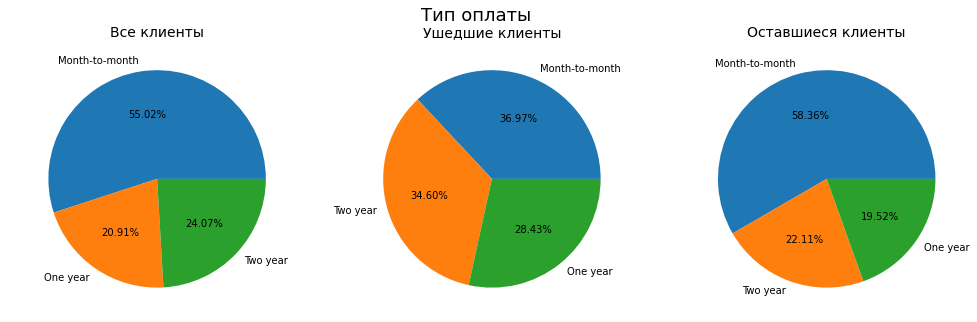

In [54]:
category_plot('type', 'Тип оплаты')

* В выборке представлены оплаты трёх типов: помесячная, ежегодная и раз в два года. Чуть больше половины клиентов платят раз в месяц. 24.07% платят сразу за два года, и 21.91% оплачивают услуги раз в год.
* Среди клиентов, разорвавших контракт, оказалось практически поровну тех, кто оплачивал услуги ежемесячно (36.97%) и тех, кто выбирал платить сразу за два года (34.60%).

### Электронный расчётный лист
Посмотрим, как распределены клиенты по способу получения счёта за услуги.

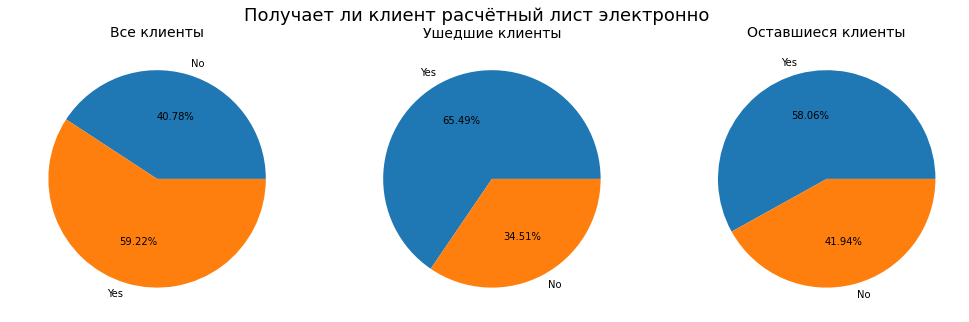

In [55]:
category_plot('paperless_billing', 'Получает ли клиент расчётный лист электронно')

* 59.22% клиентов предпочитают получать счёт за услуги электронно, 40.78% получают по-старинке, в бумаге.
* Ушедшие клиенты чуть чаще предпочитали отказаться от бумажной квитанции: в 65.49% случаев.

### Тип платежа
Посмотрим, какой метод оплаты выбирают клиенты.

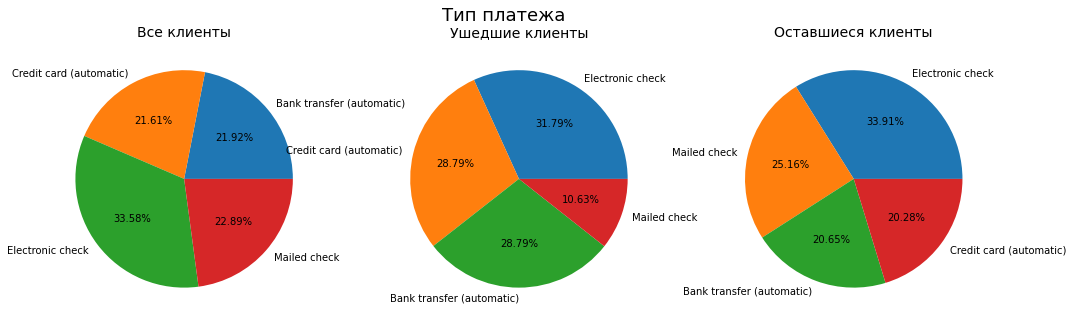

In [56]:
category_plot('payment_method', 'Тип платежа')

* На первом месте по популярности находится электронный чек: его выбирают 33.58% клиентов. Остальные три метода оплаты распределены почти равномерно: 22.89% выбирают почтовый чек, у 21.92% оплата автоматически списывается с банковского счёта и у 21.61% с кредитной карты.
* Ушедшие клиенты гораздо реже оплачивали услуги по почте (10.63%). А остальные способы выбирали примерно поровну.

### Ежемесячные расходы
Посмотрим на то, как распределяются клиенты по сумме ежемесячных расходов.

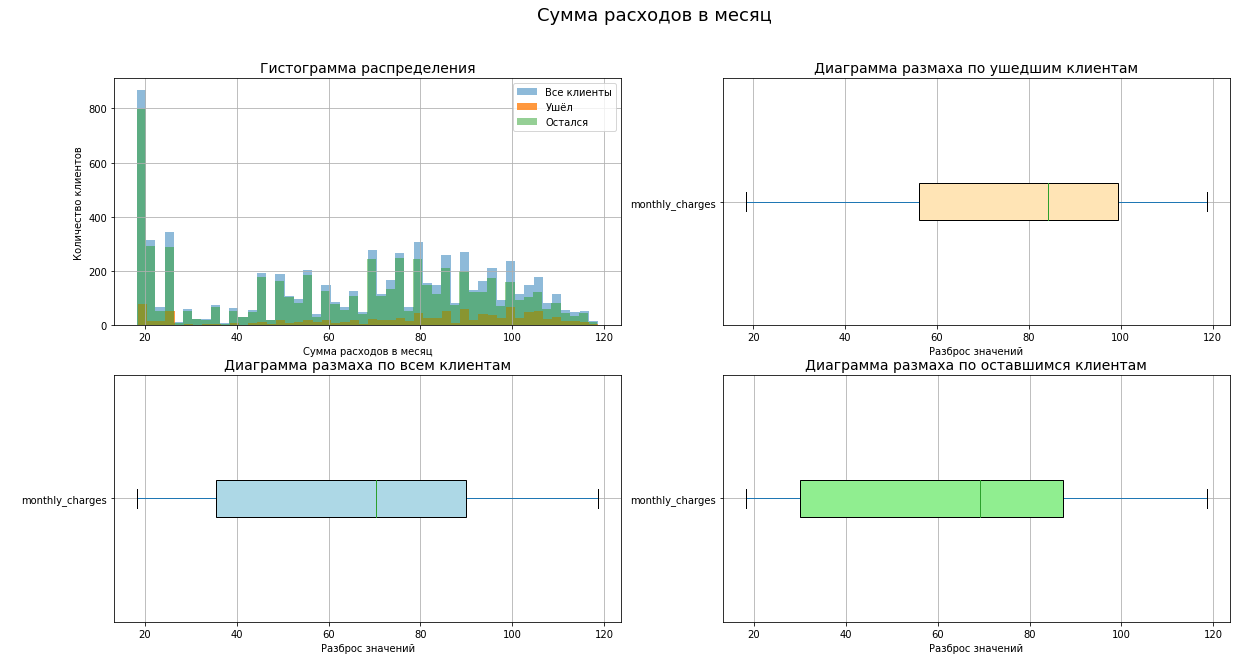

In [55]:
counts_plot('monthly_charges', 'Сумма расходов в месяц', 30)

In [56]:
monthly_charges = pd.DataFrame(
    zip(df['monthly_charges'].describe(),
        df.query('cancelled == "Yes"')['monthly_charges'].describe(),
        df.query('cancelled == "No"')['monthly_charges'].describe()
        )
)
monthly_charges.columns = ['all_clients', 'cancelled_yes', 'cancelled_no']
monthly_charges['index'] = pd.DataFrame(df['monthly_charges'].describe()).reset_index()['index']
monthly_charges.set_index('index')

,all_clients,cancelled_yes,cancelled_no
index,,,
count,7043.000000,1101.000000,5942.000000
mean,64.761692,75.546004,62.763455
std,30.090047,29.116213,29.844462
min,18.250000,18.400000,18.250000
25%,35.500000,56.150000,30.062500
50%,70.350000,84.200000,69.200000
75%,89.850000,99.500000,87.237500
max,118.750000,118.750000,118.600000


* Распределение не носит характер нормального. Средний клиент тратит в месяц порядка 70 руб. Траты основной массы клиентов сосредоточены в интервале от 35.50 до 89.85 руб. в месяц.
* Ушедшие клиенты в среднем тратили в месяц больше денег чем те, которые остались: их медианная сумма ежемесячных трат составляет 84.20 руб, а основная масса значений лежит в диапазоне от 56.15% до 99.50%.

На гистограмме видно необычайно большое число пользователей, тратящих в месяц меньше 20 руб. Посмотрим на них.

In [57]:
df.query('monthly_charges <= 20').sample(5)

,customer_id,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,phone,total_days,cancelled
4694,0594-UFTUL,Month-to-month,Yes,Mailed check,19.85,258.05,Male,No,Yes,Yes,No,No,No,No,No,No,No,No,Yes,396,No
2354,9424-CMPOG,Two year,No,Mailed check,19.60,176.40,Male,No,Yes,Yes,No,No,No,No,No,No,No,No,Yes,276,No
842,1038-ZAGBI,One year,No,Bank transfer (automatic),19.80,316.80,Female,No,Yes,Yes,No,No,No,No,No,No,No,No,Yes,488,No
5555,8750-QWZAJ,Two year,No,Bank transfer (automatic),19.80,1427.58,Female,No,Yes,Yes,No,No,No,No,No,No,No,No,Yes,2132,No
1814,5442-PPTJY,Two year,No,Mailed check,19.70,252.95,Male,No,Yes,Yes,No,No,No,No,No,No,No,No,Yes,365,No


Похоже, что это клиенты, не пользующиеся услугами интернета, только телефонией.

### Совокупные расходы
Посмотрим на распределение клиентов по общей сумме расходов.

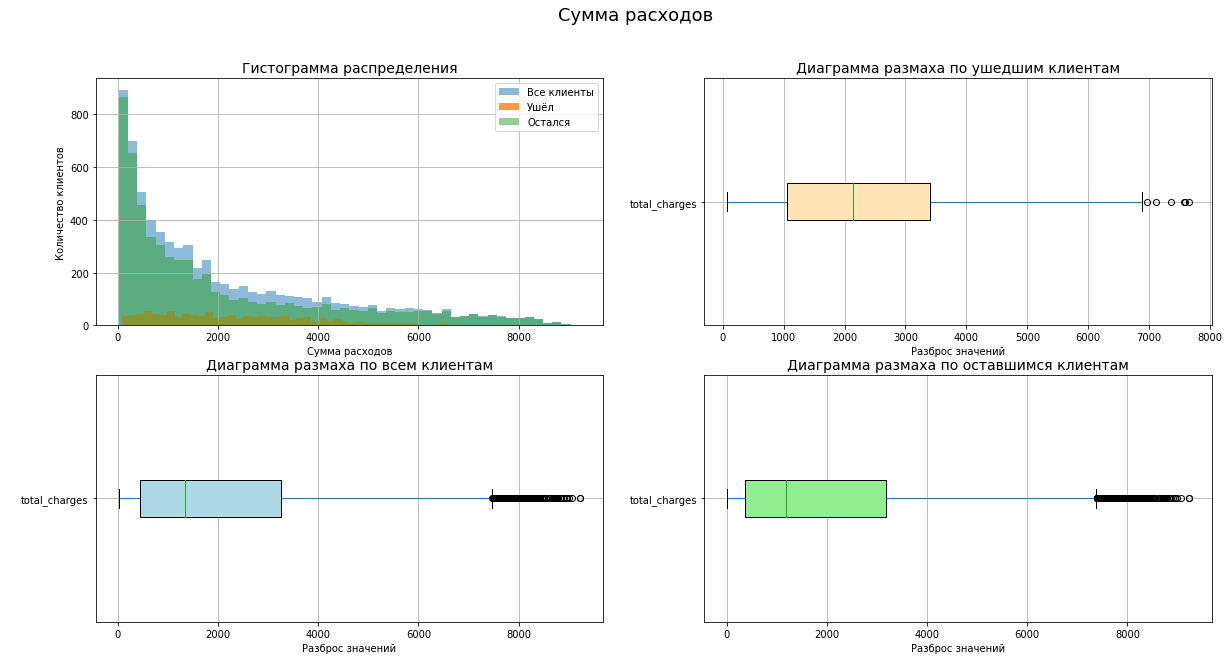

In [58]:
counts_plot('total_charges', 'Сумма расходов', 30)

In [59]:
total_charges = pd.DataFrame(
    zip(df['total_charges'].describe(),
        df.query('cancelled == "Yes"')['total_charges'].describe(),
        df.query('cancelled == "No"')['total_charges'].describe()
        )
)
total_charges.columns = ['all_clients', 'cancelled_yes', 'cancelled_no']
total_charges['index'] = pd.DataFrame(df['total_charges'].describe()).reset_index()['index']
total_charges.set_index('index')

,all_clients,cancelled_yes,cancelled_no
index,,,
count,7043.000000,1101.000000,5942.000000
mean,2120.553699,2371.377275,2074.078310
std,2113.656071,1581.862275,2195.073843
min,19.050000,77.840000,19.050000
25%,439.975000,1048.050000,376.625000
50%,1346.420000,2139.030000,1196.160000
75%,3253.000000,3404.910000,3178.580000
max,9221.380000,7649.760000,9221.380000


* Распределение не носит характер нормального. Чем больше общая сумма расходов, тем меньше таких пользователей. Звучит логично, ведь в нашем датасете представлены данные за несколько лет, и с течением времени общее количество клиентов в базе растёт. Пользователи, чья сумма расходов за всё время составила меньше 20 руб., скорее всего являются новыми пользователями.
* Средний клиент за всё время пользование услугами потратил около 1346 руб. Траты основной массы клиентов сосредоточены в интервале от 440 до 3253 руб.
* Основная масса ушедших клиентов успела потратить от 1048.05 руб. до 3404.91 руб. Медианное значение 2139.03, что в 1.78 раз выше, чем медиана оставшихся клиентов.

### Пол клиентов
Посмотрим, кого в клиентской базе больше: мужчин или женщин.

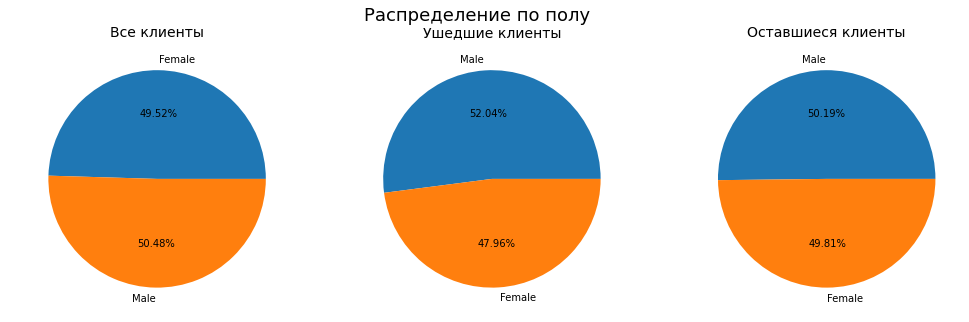

In [60]:
category_plot('gender', 'Распределение по полу')

* Клиентов практически поровну: женщин на полпроцента меньше чем мужчин.
* Если смотреть отдельно по ушедшим и отдельно по оставшимся клиентам, картина практически аналогична.

### Пенсионный возраст
Проверим, какой процент клиентов является пенсионерами.

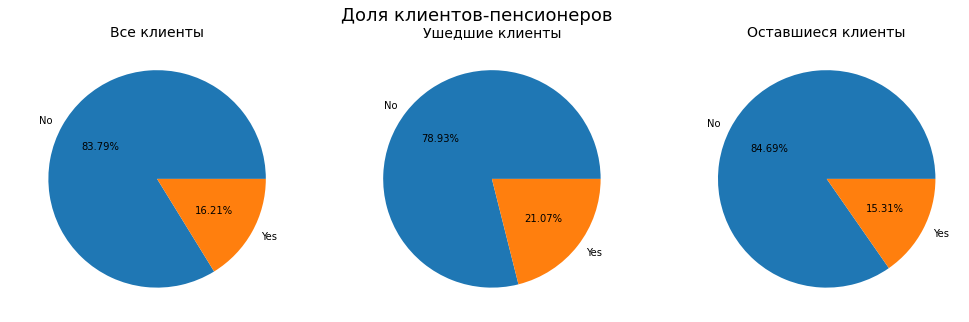

In [61]:
category_plot('senior_citizen', 'Доля клиентов-пенсионеров')

* Пенсионеров в выборке сравнительно не много: 16.21%.
* Среди ушедших клиентов доля пенсионеров составляет 21.07%.

### Семейное положение
Посмотрим, у какой доли клиентов есть супруг или супруга.

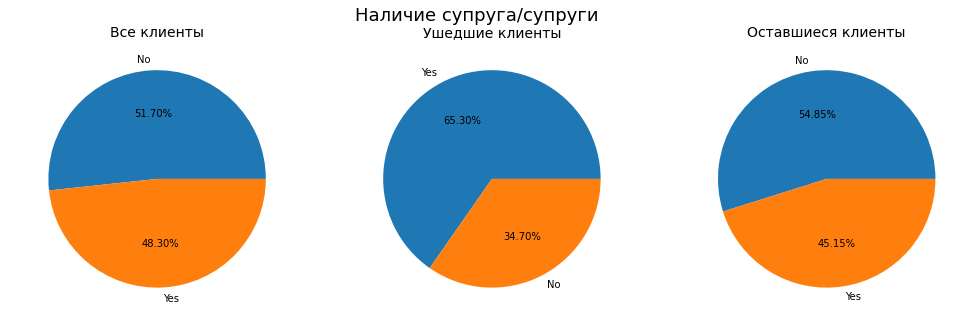

In [62]:
category_plot('partner', 'Наличие супруга/супруги')

* Клиенты разделились почти что пополам: 48.30% состоят в браке и 51.70% не состоят.
* Ушедшие клиенты чаще состоят в браке, чем оставшиеся: в 65.30% случаев.

### Наличие детей
Теперь проверим, у скольких клиентов есть дети.

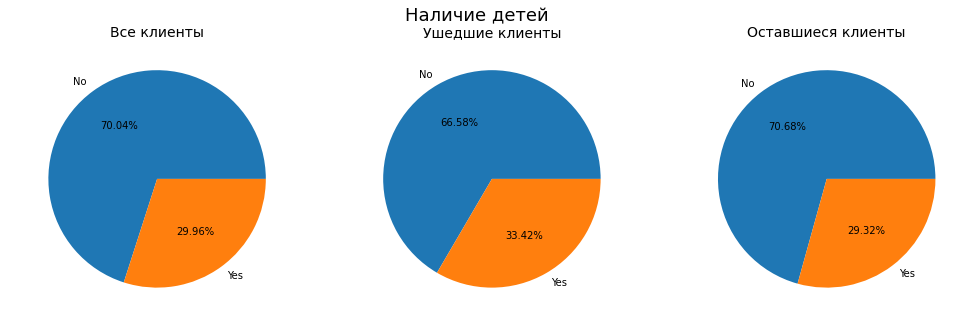

In [63]:
category_plot('dependents', 'Наличие детей')

* Дети есть почти что у 30% клиентов.
* Процент клиентов с детьми среди разорвавших контракт не сильно выше: 33.42%.

### Тип интернет-подключения
Посмотрим, какой процент пользователей пользуется услугами интернета, и какой тип соединения предпочитает.

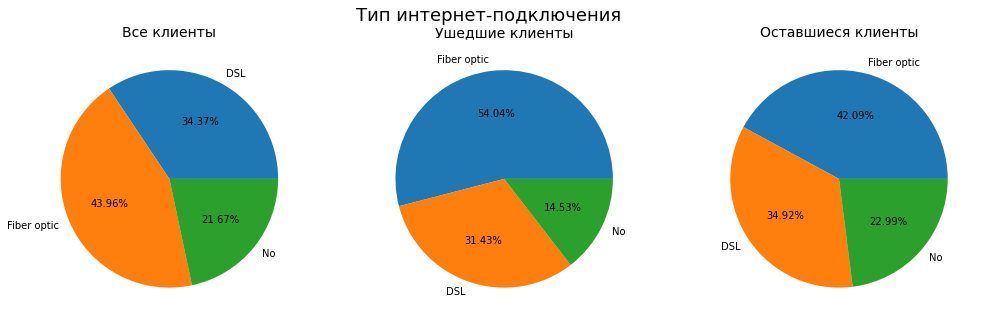

In [64]:
category_plot('internet_service', 'Тип интернет-подключения')

Подключение может быть двух типов: через телефонную линию (DSL) или оптоволоконный кабель (Fiber optic).
* 43.96% подключены через оптоволокно. 34.37% через телефонную линию. 21.67% не пользуются услугами интернета.
* Ушедшие клиенты реже не пользовались услугами интернета вовсе: всего в 14.53%. 54.04% были подключены через оптоволокно и 31.43% через телефон.

### Блокировка опасных сайтов
Посмотрим, какой процент пользователей пользуется услугами блокировщика опасных сайтов.

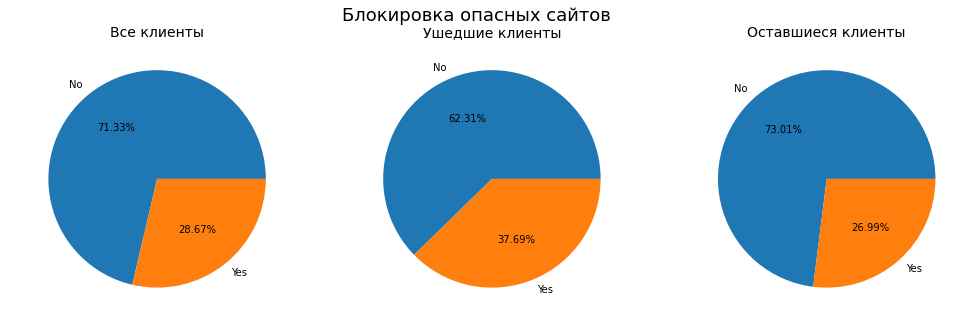

In [65]:
category_plot('online_security', 'Блокировка опасных сайтов')

* Услугами блокировщика пользуются 28.67% пользователей.
* Среди ушедших пользователей процент немного выше: 37.69%.

### Облачное хранилище и резервное копирование
Посмотрим, какая доля пользователей оплачивает доступ к облачному хранилищу для резервного копирования файлов.

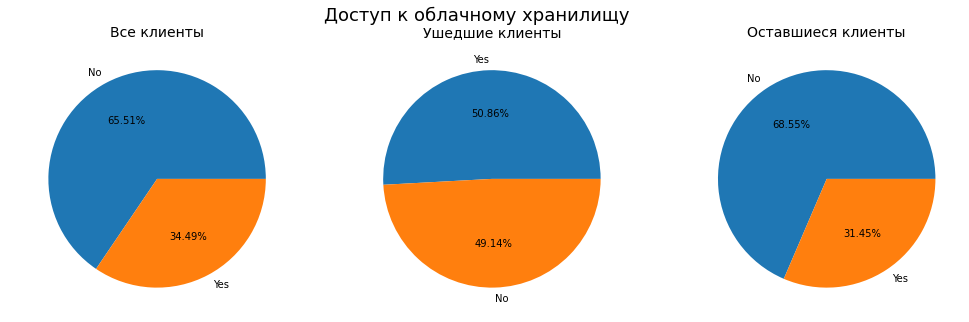

In [66]:
category_plot('online_backup', 'Доступ к облачному хранилищу')

* Всего эта услуга подключена у 34.49% клиентов.
* При этом половина (50.86%) ушедших клиентов оплачивали эту услугу.

### Антивирус
Посмотрим, какая доля пользователей пользуется услугами антивируса.

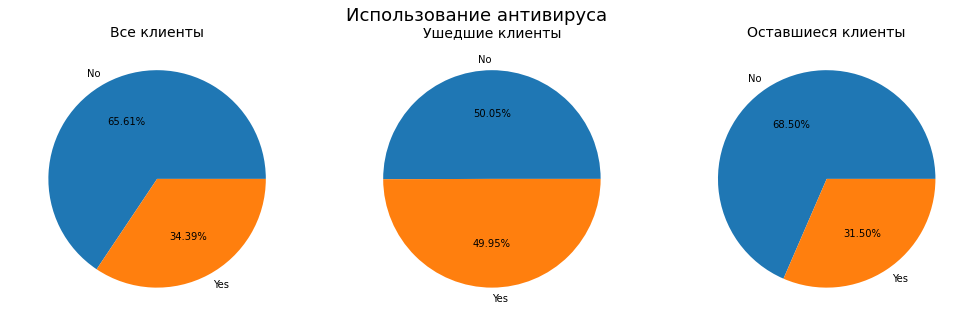

In [67]:
category_plot('device_protection', 'Использование антивируса')

* Всего эта услуга подключена у 34.39% клиентов.
* При этом половина (49.95%) ушедших клиентов оплачивали эту услугу.

### Выделенная линия техподдержки
Посмотрим, у скольких клиентов подключена выделенная линия техподдержки.

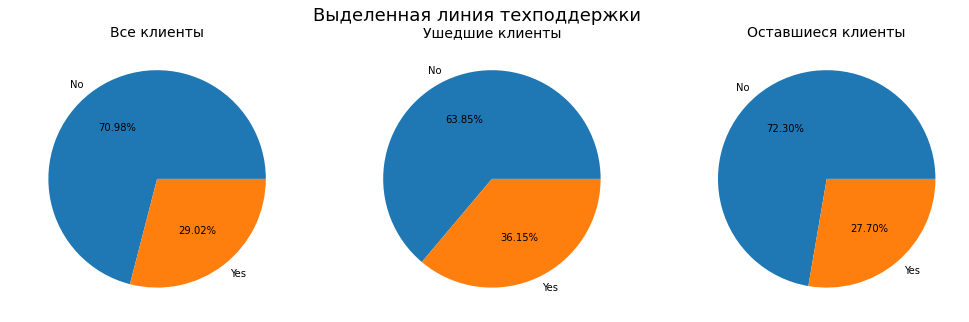

In [68]:
category_plot('tech_support', 'Выделенная линия техподдержки')

* Услугой пользовались 29.02% всех клиентов.
* Среди ушедших клиентов процент незначительно выше: 36.15%.

### Стриминговое телевидение
Посмотрим, сколько клиентов имеют доступ к стриминговому телевидению.

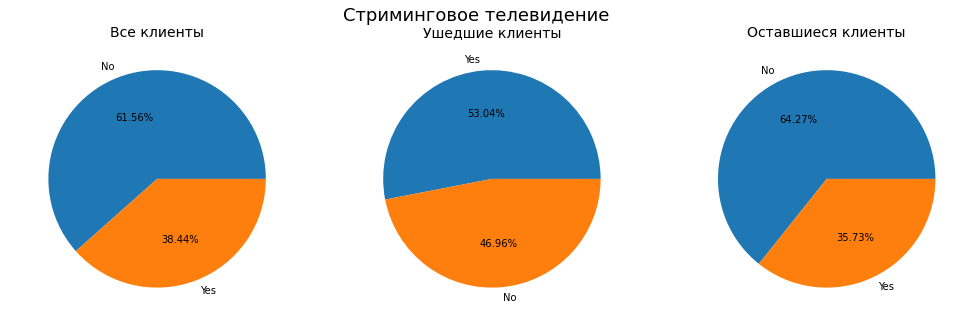

In [69]:
category_plot('streaming_tv', 'Стриминговое телевидение')

* Услугой пользуется 38.44% клиентов нашего датасета.
* При этом среди ушедших пользователей эта услуга была подключена более чем у половины: 53.04%.

### Каталог фильмов
Посмотрим, сколько клиентов имеют доступ к каталогу фильмов.

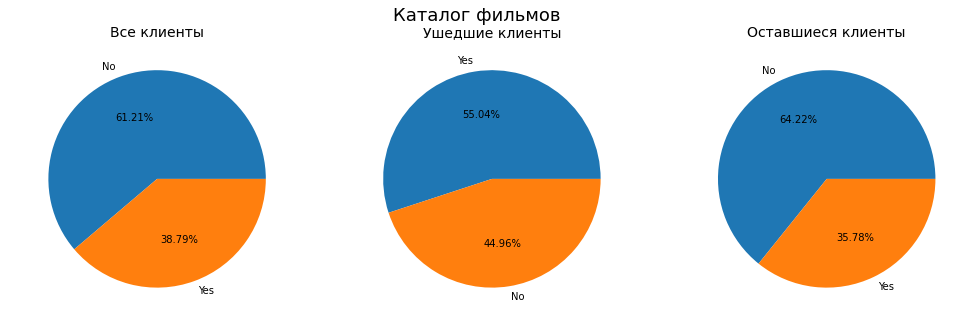

In [70]:
category_plot('streaming_movies', 'Каталог фильмов')

* Каталогом фильмов пользуются 38.79% клиентов нашего датасета.
* При этом среди ушедших пользователей эта услуга была подключена более чем у половины: 55.04%.

### Пользование услугами телефонии
Посмотрим, сколько клиентов пользуются услугами телефонии и сколько имеют больше одной линии.

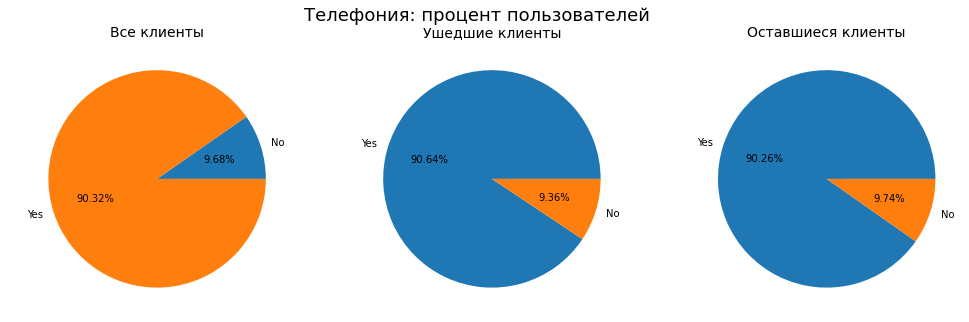

In [71]:
category_plot('phone', 'Телефония: процент пользователей')

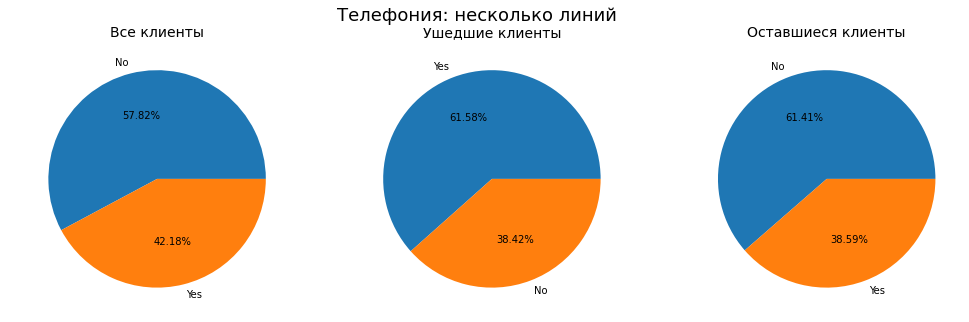

In [72]:
category_plot('multiple_lines', 'Телефония: несколько линий')

* Всего 9.68% не пользуются услугами телефонии. У 42.18% от всех пользователей подключено более 1 линии.
* Ушедшие клиенты также часто пользовались телефонией: в 90.64% случаев. А вот несколько линий имели в 61.58% случаев.

### Количество дней
Посмотрим на распределение клиентов по сроку контракта.

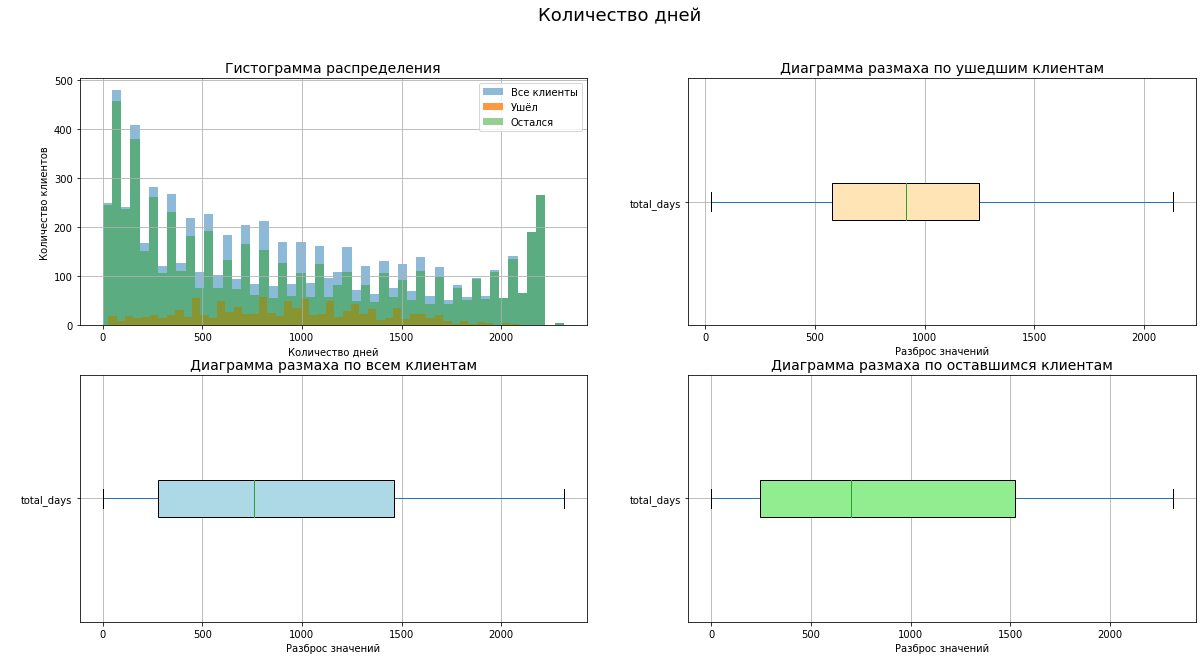

In [73]:
counts_plot('total_days', 'Количество дней', 20)

In [74]:
total_days = pd.DataFrame(
    zip(df['total_days'].describe(),
        df.query('cancelled == "Yes"')['total_days'].describe(),
        df.query('cancelled == "No"')['total_days'].describe()
        )
)
total_days.columns = ['all_clients', 'cancelled_yes', 'cancelled_no']
total_days['index'] = pd.DataFrame(df['total_days'].describe()).reset_index()['index']
total_days.set_index('index')

,all_clients,cancelled_yes,cancelled_no
index,,,
count,7043.000000,1101.000000,5942.000000
mean,898.555729,924.863760,893.681084
std,683.130510,458.771309,716.958551
min,0.000000,28.000000,0.000000
25%,276.000000,577.000000,245.000000
50%,761.000000,915.000000,702.000000
75%,1461.000000,1249.000000,1523.000000
max,2314.000000,2129.000000,2314.000000


* Распределение не носит характер нормального. Много клиентов, пользовавшихся услугами либо недолго, либо наоборот долго.
* Контракты основной массы пользователей имеют длительность от 276 до 1461 дней. В среднем, если смотреть по медиане, клиент пользуется услугами компании 761 день.
* Основная масса ушедших клиентов пользовались услугами от 577 до 1249 дней (медианное значение равняется 915 дням)

### Отток клиентов
Посмотрим, сколько клиентов отказались от услуг компании, а сколько остаются.

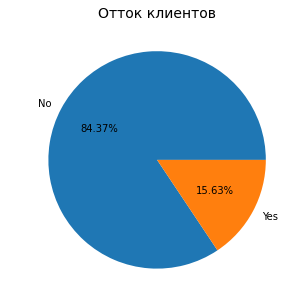

In [75]:
pivot = df.pivot_table(index='cancelled', values='customer_id', aggfunc='count')
pivot.columns = ['count']
pivot.plot(y='count', kind='pie', autopct='%1.2f%%', legend=False, figsize=(6,5))
plt.title('Отток клиентов', fontsize=14)
plt.ylabel(' ')
plt.show()

Отток клиентов составляет 15.63%. На лицо дисбалланс классов. Будем учитывать это, если нам понадобится использовать метрики, чувствительные к дисбаллансу.

### Корреляционный анализ
Построим матрицу корерляций на основе Фи-коэффициента, поскольку в наших данных в основном категориальные признаки.

In [58]:
# избавимся от столбца id, переведя его в индекс.
df = df.set_index('customer_id')

# проверим на наличие дубликатов в данных теперь.
df.duplicated().sum()

4

После преобразования customer_id  в индекс в данных обнаружилось несколько дубликатов. Удалим их.

In [59]:
df = df.drop_duplicates()

df.shape

(7039, 20)

Дубликаты удалены, можем двигаться дальше.

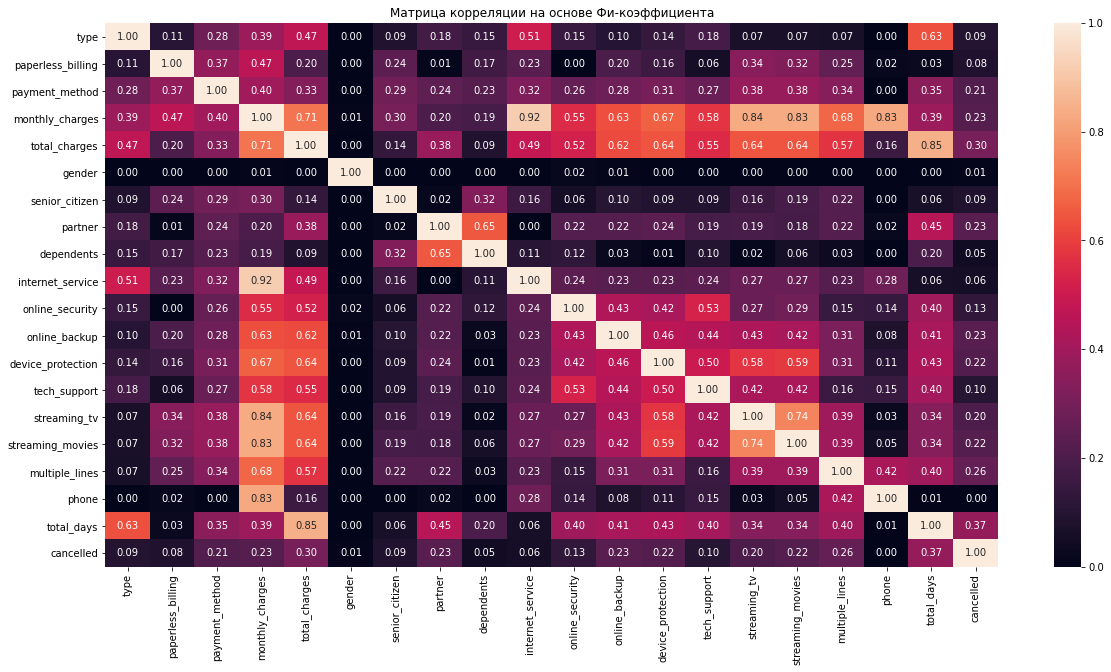

In [78]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(df.phik_matrix(interval_cols=['monthly_charges', 'total_charges', 'total_days']), annot=True, fmt='.2f')
plt.title('Матрица корреляции на основе Фи-коэффициента')
plt.show()

Целевой признак имеет наиболее сильную корреляцию с тем, сколько дней клиент пользуется услугами компании, а также с общей суммой расходов. Однако, связи выражены не сильно.

Среди входных признаков прослеживаются выраженные корреляции. Так, например, едемесячная сумма расходов тесно связана с пользованием телефонией, стриминговыми сервисами и в целом дополнительными услугами для интернет-пользователей. А общая сумма расходов коррелирует с длительностью оказания услуг: что звучит довольно логично.

Чтобы избежать проблем мультиколлинеарности, а также в связи с тем, что корреляция между входными и целевым признаками выражена не сильно, постараемся избежать регрессионных моделей.

### Вывод
Исследовав наши данные, мы выделили следующие закономерности:

* В выборке представлены оплаты трёх типов: помесячная, ежегодная и раз в два года. Чуть больше половины клиентов платят раз в месяц. 24.07% платят сразу за два года, и 21.91% оплачивают услуги раз в год. 59.22% клиентов предпочитают получать счёт за услуги электронно, 40.78% получают по-старинке, в бумаге. На первом месте по популярности находится электронный чек: его выбирают 33.58% клиентов. Остальные три метода оплаты распределены почти равномерно: 22.89% выбирают бумажный чек, у 21.92% оплата автоматически списывается с банковского счёта и у 21.61% с кредитной карты. 
* Средний клиент тратит в месяц порядка 70 руб., а суммарно за весь срок действия договора около 1346 руб. Траты основной массы клиентов сосредоточены в интервале от 35.50 до 89.85 руб. в месяц и от 440 до 3253 руб. всего. На гистограмме видно необычайно большое число пользователей, тратящих в месяц меньше 20 руб. Это пользователи, не пользующиеся интернет-услугами.
* Контракты основной массы пользователей имеют длительность от 276 до 1461 дней. В среднем, если смотреть по медиане, клиент пользуется услугами компании 761 день.
* Если смотреть распределение клиентов по полу, они распределены практически поровну: женщин на полпроцента меньше чем мужчин. Пенсионеров в выборке сравнительно не много: 16.21%. Клиенты разделились почти что пополам: 48.30% состоят в браке и 51.70% не состоят. Дети есть почти что у 30% клиентов.
* Интернет-подключение может быть двух типов: через телефонную линию (DSL) или оптоволоконный кабель (Fiber optic). 43.96% подключены через оптоволокно. 34.37% через телефонную линию. 21.67% не пользуются услугами интернета.
* Что касается дополнительных услуг, по ним наблюдается следующая картина. Услугами блокировщика пользуются 28.67% пользователей. Услуга облачного хранилища для резервного копирования подключена у 34.49% клиентов. Практически столько же клиентов пользуются услугами антивируса: 34.39%. Выделенной линией техподдержки пользуется 29.02% клиентов. Стриминговым ТВ пользуется 38.44% клиентов, и практически столько же (38.79%) — каталогом фильмов.
* Телефонией пользуются 90.32% всех пользователей. У 42.18% от общего числа пользователей подключено более 1 телефонной линии.

В процессе анализа мы получили следующий "портрет" ушедшего клиента:
* Среди клиентов, разорвавших контракт, оказалось практически поровну тех, кто оплачивал услуги ежемесячно (36.97%) и тех, кто выбирал платить сразу за два года (34.60%). Ушедшие клиенты чаще предпочитали отказаться от бумажной квитанции: в 65.49% случаев. И гораздо реже оплачивали услуги по почте (10.63%), а остальные способы выбирали примерно поровну. 
* Ушедшие клиенты в среднем тратили в месяц больше денег чем те, которые остались: их медианная сумма ежемесячных трат составляет 84.20 руб, а основная масса значений лежит в диапазоне от 56.15% до 99.50%. Большая часть таких клиентов успели потратить от 1048.05 руб. до 3404.91 руб. за весь период пользования услугами. Медианное значение равняется 2139.03 руб., что в 1.78 раз выше, чем медиана оставшихся клиентов. Основная масса ушедших клиентов пользовались услугами от 577 до 1249 дней (медианное значение равняется 915 дням).
* Что касается интернет-услуг, ушедшие клиенты реже не пользовались услугами интернета вовсе: всего в 14.53%. 54.04% были подключены через оптоволокно и 31.43% через телефон. При этом ушедшие клиенты значительно чаще были подписаны на дополнительные сервисы, за исключением выделенной линии техподдержки. А если говорить о телефонии, они также часто пользовались этой услугой, как и все остальные: в 90.64% случаев. Но несколько линий имели аж в 61.58% случаев.
* Распределение таких признаков как пол, пенсионный возраст, наличие детей среди ушедших клиентов незначительно отличается от распределения по всей клиентской базе или же по оставшимся клиентам. Чего не скажешь о семейном положении: ушедшие клиенты чаще состоят в браке, чем оставшиеся: в 65.30% случаев.

Корреляционный анализ принёс следующие результаты:
* Целевой признак имеет наиболее сильную корреляцию с тем, сколько дней клиент пользуется услугами компании, а также с общей суммой расходов. Однако, связи выражены не сильно.
* Среди входных признаков прослеживаются выраженные корреляции. Так, например, едемесячная сумма расходов тесно связана с пользованием телефонией, стриминговыми сервисами и в целом дополнительными услугами для интернет-пользователей. А общая сумма расходов коррелирует с длительностью оказания услуг: что звучит довольно логично.

Всё это позволяет нам сделать следующие выводы о дальнейшей работе над проектом:
* Чтобы избежать проблем мультиколлинеарности, а также в связи с тем, что корреляция между входными и целевым признаками выражена не сильно, постараемся избежать регрессионных моделей.
* Для обучения модели исключим из выборки признаки, распределение которых для ушедших клиентов не носит такой же характер, как для всех остальных (пол, пенсионный возраст, наличие детей, пользование телефонией (пользование несколькими линиями телефонии сохраним), использование выделенной линии техподдержки и блокировщика опасных сайтов. Также уберём информацию о стриминговом ТВ: судя по графикам, подписка на этот сервис скорее всего идёт вместе с каталогом фильмов, а по нему корреляция выше.

## Подготовка данных
На этом шаге мы подготовим наши данные непосредственно для машинного обучения:
* отберём признаки
* обозначим константы
* разобъём данные на выборки
* разделим признаки на категориальные и количественные
* закодируем целевой признак
* создадим словари для подбора гиперпараметров
* напишем пайплайн обучения моделей, содердащий в себе в том числе кодирование и масштабирование признаков, который будем потом использовать на всех выбранных нами моделях кроме бустинговых.

In [60]:
# удалим признаки, которые мы решили не использовать
df = df.drop(columns=['gender', 'senior_citizen', 'dependents', 'phone', 'tech_support', 'online_security',
                    'streaming_tv'], axis=1)

In [61]:
# обозначим константы
RANDOM_STATE = 40324
TEST_SIZE = 0.25

In [62]:
# разобьем данные на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=['cancelled'], axis=1),
    df['cancelled'],
    stratify=df['cancelled'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE)

X_train.shape, X_test.shape

((5279, 12), (1760, 12))

In [63]:
cat_features = ['type', 'paperless_billing', 'payment_method', 'partner',
               'internet_service', 'online_backup', 'device_protection',
                'streaming_movies', 'multiple_lines']
num_features = ['monthly_charges', 'total_charges', 'total_days']

# для бустинговых моделей изменим тип категориальных признаков
for i in cat_features:
    df[i] = df[i].astype('category')

In [83]:
# закодируем значения целевого признака
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# убедимся, что кодировщик принял за 1 значение 'Yes' и за 0 'No'
pred_classes = [1, 0]
label_encoder.inverse_transform(pred_classes)

array(['Yes', 'No'], dtype=object)

In [84]:
# словарь для модели DecisionTreeClassifier()
param_grid_tree = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 100),
        'models__max_features': range(2, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]
    
# словарь для модели KNeighborsClassifier()
param_grid_knn = [
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    }  
]

# словарь для модели CatBoostClassifier()
param_grid_cat = [
    {
        'iterations': [10, 50, 100, 200, 300, 400, 500],
        'max_depth': [2, 5, 10, 20, 50, 100]
    }
]

In [85]:
# создадим пайплайн для подготовки категориальных признаков: заполнение пропусков и Ordinal-кодирование
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

# создадим общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ord', ord_pipe, cat_features),
     ('num', StandardScaler(), num_features)
    ], 
    remainder='passthrough'
)

# создадим итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

## Обучение моделей

### Дерево решений

In [86]:
tree_search = RandomizedSearchCV(
    pipe_final,
    param_grid_tree,
    n_jobs=-1,
    cv=5,
    random_state=RANDOM_STATE,
    scoring='roc_auc'
)

In [87]:
tree_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ord',
                                                                               Pipeline(steps=[('simpleImputer_before_ord',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ord',
                                                                                                OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                               unknown_value=nan)),
                                                                                               ('simpleImputer_after_ord',
                                                                                                SimpleImputer(strategy='most_fre...
                                                                                'total_charges',
                                                                                'total_days'])])),
                                             ('models',
                                              DecisionTreeClassifier(random_state=40324))]),
                   n_jobs=-1,
                   param_distributions=[{'models': [DecisionTreeClassifier(random_state=40324)],
                                         'models__max_depth': range(2, 100),
                                         'models__max_features': range(2, 20),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=40324, scoring='roc_auc')

In [88]:
tree_roc_auc = np.round(tree_search.best_score_, 3)
print(f'Метрика ROC-AUC при кросс-валидации: {tree_roc_auc}')
print(f'Параметры для лучшей модели: {tree_search.best_params_}')

Метрика ROC-AUC при кросс-валидации: 0.638
Параметры для лучшей модели: {'preprocessor__num': StandardScaler(), 'models__max_features': 19, 'models__max_depth': 57, 'models': DecisionTreeClassifier(random_state=40324)}


### Модель kNN

In [89]:
knn_search = RandomizedSearchCV(
    pipe_final,
    param_grid_knn,
    n_jobs=-1,
    cv=5,
    random_state=RANDOM_STATE,
    scoring='roc_auc'
)

In [90]:
knn_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ord',
                                                                               Pipeline(steps=[('simpleImputer_before_ord',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ord',
                                                                                                OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                               unknown_value=nan)),
                                                                                               ('simpleImputer_after_ord',
                                                                                                SimpleImputer(strategy='most_fre...
                                                                                'multiple_lines']),
                                                                              ('num',
                                                                               StandardScaler(),
                                                                               ['monthly_charges',
                                                                                'total_charges',
                                                                                'total_days'])])),
                                             ('models',
                                              DecisionTreeClassifier(random_state=40324))]),
                   n_jobs=-1,
                   param_distributions=[{'models': [KNeighborsClassifier()],
                                         'models__n_neighbors': range(2, 10),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=40324, scoring='roc_auc')

In [91]:
knn_roc_auc = np.round(knn_search.best_score_, 3)
print(f'Метрика ROC-AUC при кросс-валидации: {knn_roc_auc}')
print(f'Параметры для лучшей модели: {knn_search.best_params_}')

Метрика ROC-AUC при кросс-валидации: 0.761
Параметры для лучшей модели: {'preprocessor__num': StandardScaler(), 'models__n_neighbors': 8, 'models': KNeighborsClassifier()}


### Бустинговая модель

In [92]:
cat_model = CatBoostClassifier(random_state=RANDOM_STATE)

In [93]:
cat_search = RandomizedSearchCV(
    cat_model,
    param_grid_cat,
    n_jobs=-1,
    cv=5,
    random_state=RANDOM_STATE,
    scoring='roc_auc'
)

In [94]:
cat_search.fit(X_train, y_train, cat_features=cat_features, verbose=False)

RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostClassifier object at 0x7f1a0a180f10>,
                   n_jobs=-1,
                   param_distributions=[{'iterations': [10, 50, 100, 200, 300,
                                                        400, 500],
                                         'max_depth': [2, 5, 10, 20, 50, 100]}],
                   random_state=40324, scoring='roc_auc')

In [95]:
cat_roc_auc = np.round(cat_search.best_score_, 3)
print(f'Метрика ROC-AUC при кросс-валидации: {cat_roc_auc}')
print(f'Параметры для лучшей модели: {cat_search.best_params_}')

Метрика ROC-AUC при кросс-валидации: 0.866
Параметры для лучшей модели: {'max_depth': 5, 'iterations': 400}


### Выбор лучшей модели

In [96]:
models_results = pd.DataFrame({'model': ['DecisionTreeClassifier', 'KNeighborsClassifier', 'CatBoostClassifier'], 
                               'ROC-AUC': [tree_roc_auc, knn_roc_auc, cat_roc_auc]}
                             )

models_results

,model,ROC-AUC
0,DecisionTreeClassifier,0.638
1,KNeighborsClassifier,0.761
2,CatBoostClassifier,0.866


Лучшей моделью себя показала CatBoostClassifier с гиперпараметрами: max_depth = 5, iterations = 400.

### Вывод
На этом шаге мы выбрали и обучили три модели, подобрав для каждой оптимальные гиперпараметры:
* DecisionTreeClassifier
* KNeighborsClassifier
* CatBoostClassifier

Лучшей себя показала модель CatBoostClassifier с гиперпараметрами: max_depth = 5, iterations = 400.

## Проверка и интерпретация лучшей модели
### Проверка модели на тестовых данных
Выполним предсказание на тестовых данных.

In [97]:
y_pred = cat_search.predict(X_test)
y_proba = cat_search.predict_proba(X_test)[:,1]
print(f'Метрика ROC-AUC на тестовой выборке: {np.round(roc_auc_score(y_test, y_proba), 3)}')

Метрика ROC-AUC на тестовой выборке: 0.898


Результат укладывается в поставленное нам условие: значение метрики не меньше 0.85.

### Анализ важности признаков

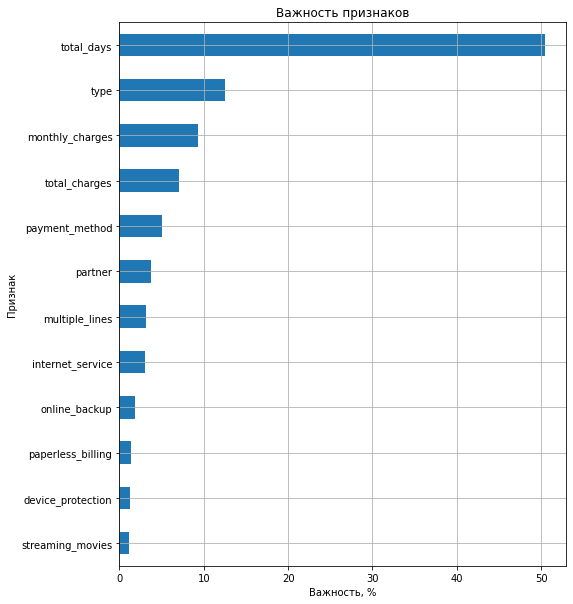

In [98]:
features = cat_search.best_estimator_.get_feature_importance(prettified=True).set_index('Feature Id')

features.sort_values('Importances').plot(kind='barh', legend=False, grid=True, figsize=(8, 10))
plt.title("Важность признаков")
plt.xlabel('Важность, %')
plt.ylabel('Признак')
plt.show()

Наибольший вклад в работу модели вносит срок контракта в днях. Также в топе-5 важности признаков находятся тип оплаты, размер ежемесячного платежа и совокупных расходов, тип платежа.

### Анализ ошибок модели
Заказчик планирует бороться с оттоком клиентов, предлагая промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Если модель ошибётся и не предскажет уход клиента, клиент не получит промокод и не изменит своего решения. Это означает, что в данном случае нам больше подходит метрика Recall.

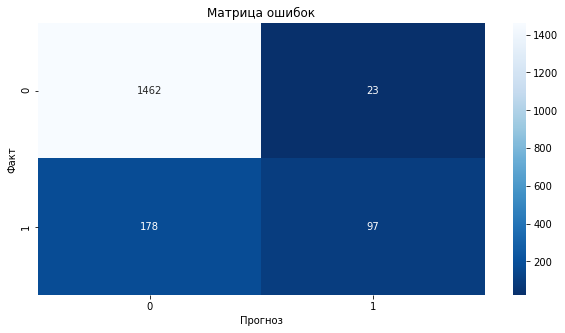

In [99]:
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.xlabel('Прогноз')
plt.ylabel('Факт')
plt.title('Матрица ошибок')
plt.show()

In [100]:
acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, pos_label=1)
precision = precision_score(y_test, y_pred, pos_label=1)
print('Accuracy =', round(acc ,3))
print('Recall =', round(recall ,3))
print('Precision =', round(precision ,3))

Accuracy = 0.886
Recall = 0.353
Precision = 0.808


Несмотря на то, что наша модель ошибается всего в 11.4% случаев, она не всегда верно предсказывает уход клиента. В том, чтобы не упускать таких клиентов из вида, нам помогут пороги классификации.

In [101]:
# определим пороги и вероятности
thresholds = [round(i,2) for i in np.linspace(0.1, 1, num=20, endpoint=False)]

# создадим датафрейм, содержащий прогнозы для каждого из порогов
proba_thresholds = pd.DataFrame(zip(y_test, y_pred, y_proba),
             columns=['y_test', 'y_pred', 'y_proba']).sort_values(by='y_proba',ascending=False)
columns = []
for i in thresholds:
    columns.append('y_pred_'+str(i))
    proba_thresholds['y_pred_'+str(i)] = proba_thresholds['y_proba'].apply(
        lambda y_proba : 1 if y_proba >= i else 0
    )

proba_thresholds.sample(5)

,y_test,y_pred,y_proba,y_pred_0.1,y_pred_0.15,y_pred_0.19,y_pred_0.24,y_pred_0.28,y_pred_0.32,y_pred_0.37,y_pred_0.42,y_pred_0.46,y_pred_0.5,y_pred_0.55,y_pred_0.6,y_pred_0.64,y_pred_0.68,y_pred_0.73,y_pred_0.77,y_pred_0.82,y_pred_0.86,y_pred_0.91,y_pred_0.96
1299,0,0,0.139584,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
294,1,1,0.702639,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0
73,0,0,0.065973,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
690,0,0,0.197705,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
290,0,0,0.021413,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [102]:
# рассчитаем recall и precision в зависимости от порога
TP = []
FN = []
FP = []
recall = []
for i in thresholds:
    TP.append(proba_thresholds.query(f'(y_test == 1) and (y_proba >= {i})')['y_test'].count())
    FN.append(proba_thresholds.query(f'(y_test == 1) and (y_proba < {i})')['y_test'].count())
    FP.append(proba_thresholds.query(f'(y_test == 0) and (y_proba >= {i})')['y_test'].count())

metrics = pd.DataFrame(zip(thresholds, TP, FN, FP), columns=['threshold', 'TP', 'FN', 'FP'])

metrics['recall'] = metrics['TP'] / (metrics['TP'] + metrics['FN'])
metrics['precision'] = metrics['TP'] / (metrics['TP'] + metrics['FP'])

metrics

,threshold,TP,FN,FP,recall,precision
0,0.10,256,19,518,0.930909,0.330749
1,0.15,236,39,356,0.858182,0.398649
2,0.19,212,63,242,0.770909,0.466960
3,0.24,191,84,160,0.694545,0.544160
4,0.28,172,103,120,0.625455,0.589041
5,0.32,161,114,98,0.585455,0.621622
6,0.37,145,130,65,0.527273,0.690476
7,0.42,125,150,47,0.454545,0.726744
8,0.46,112,163,30,0.407273,0.788732
9,0.50,97,178,23,0.352727,0.808333


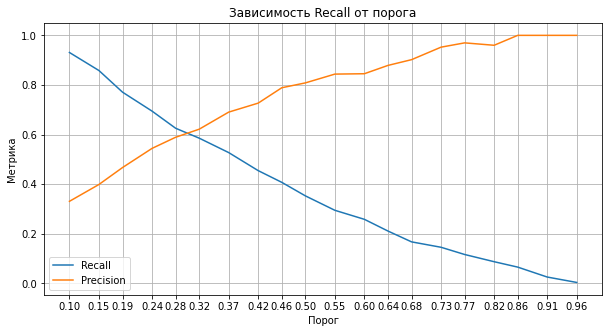

In [103]:
# построим график зависимости метрик от порога
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(x=metrics['threshold'], y=metrics['recall'], label='Recall')
sns.lineplot(x=metrics['threshold'], y=metrics['precision'], label='Precision')
plt.xlabel('Порог')
plt.ylabel('Метрика')
plt.title('Зависимость Recall от порога')
plt.grid(True)
plt.xticks(thresholds)
plt.show()

Теперь мы видим, как будут меняться наши предсказания при разных порогах классификации. На основе этих данных и сведениях о доходах компании, заказчик сможет рассчитать наиболее выгодную стратегию выдачи промокодов: как не сохранить прибыль, снизив отток клиентов, но при этом не потерять слишком много, случайно выдав промокоды тем, кто не собирался уходить.

## Отчёт по проекту

Перед нами стояла задача обучить модель для прогноза оттока клиентов оператора связи «ТелеДом». То есть — задача бинарной классификации: отказ от пользования услугами, предоставляемыми заказчиком, или  продолжение сотрудничества.

В качестве **основной метрики** для оценки качества модели мы использовали **Roc-Auc** (нужно было получить результат **не ниже 0.85**). С помощью дополнительной метрики, **Accuracy**, мы интерпретировали работу модели (используя матрицу ошибок).

В ходе работы мы придерживались нашего изначального **плана** и выполнили все шаги из него:
1. Загрузить данные и ознакомиться с ними.
2. Выполнить предобработку данных каждого датафрейма.
3. Объединить данные в один датафрейм.
4. Провести исследовательский анализ данных, включая корреляционный анализ.
5. Подготовить данные для обучения моделей.
6. Обучить разные модели, с подбором гиперпараметров, чтобы выбрать лучшую.
7. Проверить качество лучшей модели на тестовой выборке и сделать выводы о работе модели.
8. Сформулировать итоговые выводы в этом отчёте.

Ознакомившись с данными, мы провели **предобработку данных** в каждом из четырёх файлов:

1. Привели названия столбцов к «змеиному регистру».
2. Проверили данные на наличие дубликатов (в изначальных данных дубликаты отсутствовали, однако, после объединения данных в один датафрейм и избавления от идентификаторов пользователей, мы обнаружили 4 дубликата, которые удалили).
3. Заполнили  пропуски:
* При первичной предобработке явные пропуски в данных отсутствовали
* До объединения данных неявные пропуски в полях end_date (месяцем, следующим после последнего в нашем датасете, чтобы суметь посчитать срок договора в днях) и total_charges (нулями, как для новых клиентов, ещё не успевших накопить расходов).
* После объединения данных в один датасет образовавшиеся пропуски заполнили значением No
4. Исправили типы данных, где это было необходимо:
* В полях begin_date, end_date привели его к типу данных для работы с датой и временем.
* В поле total_charges исправили тип данных на float.
5. Проверили данные на наличие в них ошибок, опечаток в значениях категориальных признаков, аномально малых или аномально больших значений в количественных признаках, а также распределения значений в категориальных признаках. По итогам проверки ошибки не обнаружены.
6. Мы объединили данные в одну таблицу (df), убедившись, что информация ни о ком из клиентов не потерялась в процессе объединения.
7. Рассчитали новый признак, равный количеству дней, которое клиент пользовался услугами компании: total_days
8. Сгенерировали наш целевой признак на основе данных о дате расторжении контракта: cancelled.
9. Удалили лишние признаки: begin_date и end_date

Исследовав наши данные, мы выделили следующие **закономерности**:

* В выборке представлены оплаты трёх типов: помесячная, ежегодная и раз в два года. Чуть больше половины клиентов платят раз в месяц. 24.07% платят сразу за два года, и 21.91% оплачивают услуги раз в год. 59.22% клиентов предпочитают получать счёт за услуги электронно, 40.78% получают по-старинке, в бумаге. На первом месте по популярности находится электронный чек: его выбирают 33.58% клиентов. Остальные три метода оплаты распределены почти равномерно: 22.89% выбирают бумажный чек, у 21.92% оплата автоматически списывается с банковского счёта и у 21.61% с кредитной карты. 
* Средний клиент тратит в месяц порядка 70 руб., а суммарно за весь срок действия договора около 1346 руб. Траты основной массы клиентов сосредоточены в интервале от 35.50 до 89.85 руб. в месяц и от 440 до 3253 руб. всего. На гистограмме видно необычайно большое число пользователей, тратящих в месяц меньше 20 руб. Это пользователи, не пользующиеся интернет-услугами.
* Контракты основной массы пользователей имеют длительность от 276 до 1461 дней. В среднем, если смотреть по медиане, клиент пользуется услугами компании 761 день.
* Если смотреть распределение клиентов по полу, они распределены практически поровну: женщин на полпроцента меньше чем мужчин. Пенсионеров в выборке сравнительно не много: 16.21%. Клиенты разделились почти что пополам: 48.30% состоят в браке и 51.70% не состоят. Дети есть почти что у 30% клиентов.
* Интернет-подключение может быть двух типов: через телефонную линию (DSL) или оптоволоконный кабель (Fiber optic). 43.96% подключены через оптоволокно. 34.37% через телефонную линию. 21.67% не пользуются услугами интернета.
* Что касается дополнительных услуг, по ним наблюдается следующая картина. Услугами блокировщика пользуются 28.67% пользователей. Услуга облачного хранилища для резервного копирования подключена у 34.49% клиентов. Практически столько же клиентов пользуются услугами антивируса: 34.39%. Выделенной линией техподдержки пользуется 29.02% клиентов. Стриминговым ТВ пользуется 38.44% клиентов, и практически столько же (38.79%) — каталогом фильмов.
* Телефонией пользуются 90.32% всех пользователей. У 42.18% от общего числа пользователей подключено более 1 телефонной линии.

В процессе анализа мы получили следующий **«портрет» ушедшего клиента**:
* Среди клиентов, разорвавших контракт, оказалось практически поровну тех, кто оплачивал услуги ежемесячно (36.97%) и тех, кто выбирал платить сразу за два года (34.60%). Ушедшие клиенты чаще предпочитали отказаться от бумажной квитанции: в 65.49% случаев. И гораздо реже оплачивали услуги по почте (10.63%), а остальные способы выбирали примерно поровну. 
* Ушедшие клиенты в среднем тратили в месяц больше денег чем те, которые остались: их медианная сумма ежемесячных трат составляет 84.20 руб, а основная масса значений лежит в диапазоне от 56.15% до 99.50%. Большая часть таких клиентов успели потратить от 1048.05 руб. до 3404.91 руб. за весь период пользования услугами. Медианное значение равняется 2139.03 руб., что в 1.78 раз выше, чем медиана оставшихся клиентов. Основная масса ушедших клиентов пользовались услугами от 577 до 1249 дней (медианное значение равняется 915 дням).
* Что касается интернет-услуг, ушедшие клиенты реже не пользовались услугами интернета вовсе: всего в 14.53%. 54.04% были подключены через оптоволокно и 31.43% через телефон. При этом ушедшие клиенты значительно чаще были подписаны на дополнительные сервисы, за исключением выделенной линии техподдержки. А если говорить о телефонии, они также часто пользовались этой услугой, как и все остальные: в 90.64% случаев. Но несколько линий имели аж в 61.58% случаев.
* Распределение таких признаков как пол, пенсионный возраст, наличие детей среди ушедших клиентов незначительно отличается от распределения по всей клиентской базе или же по оставшимся клиентам. Чего не скажешь о семейном положении: ушедшие клиенты чаще состоят в браке, чем оставшиеся: в 65.30% случаев.

**Корреляционный анализ** принёс следующие результаты:
* Целевой признак имеет наиболее сильную корреляцию с тем, сколько дней клиент пользуется услугами компании, а также с общей суммой расходов. Однако, связи выражены не сильно.
* Среди входных признаков прослеживаются выраженные корреляции. Так, например, едемесячная сумма расходов тесно связана с пользованием телефонией, стриминговыми сервисами и в целом дополнительными услугами для интернет-пользователей. А общая сумма расходов коррелирует с длительностью оказания услуг: что звучит довольно логично.

Всё это позволило нам сделать следующие **выводы о работе над проектом**:

* Чтобы избежать проблем мультиколлинеарности, а также в связи с тем, что корреляция между входными и целевым признаками выражена не сильно, постараемся избежать регрессионных моделей.
* Для обучения модели нам стоит исключить из выборки признаки, распределение которых для ушедших клиентов не носит такой же характер, как для всех остальных (пол, пенсионный возраст, наличие детей, пользование телефонией (пользование несколькими линиями телефонии сохраним), использование выделенной линии техподдержки и блокировщика опасных сайтов. Также уберём информацию о стриминговом ТВ: судя по графикам, подписка на этот сервис скорее всего идёт вместе с каталогом фильмов, а по нему корреляция выше.

Таким образом, наш **итоговый список признаков**, на которых обучалась модель, выглядит так:
* type
* paperless_billing
* payment_method
* monthly_charges
* total_charges
* partner
* internet_service
* online_backup'
* device_protection
* streaming_movies
* multiple_lines
* total_days

In [104]:
df.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,partner,internet_service,online_backup,device_protection,streaming_movies,multiple_lines,total_days,cancelled
customer_id,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,Yes,DSL,Yes,No,No,No,31,No
5575-GNVDE,One year,No,Mailed check,56.95,2071.84,No,DSL,No,Yes,No,No,1036,No
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,No,DSL,Yes,No,No,No,123,No
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,No,DSL,No,Yes,No,No,1371,No
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,No,Fiber optic,No,No,No,No,153,No


Подготовив данные, мы выбрали для обучения **три модели**, и обучили их с подбором лучших **гиперпараметров**:

In [105]:
models_results

,model,ROC-AUC
0,DecisionTreeClassifier,0.638
1,KNeighborsClassifier,0.761
2,CatBoostClassifier,0.866


Лучшей себя показала модель **CatBoostClassifier с гиперпараметрами: max_depth = 5, iterations = 400**.

Метрика **ROC-AUC** лучшей модели при кросс-валидации: **0.866**
<br>Метрика **ROC-AUC** лучшей модели на тестовой выборке: **0.898** </br>

Наша дополнительная метрика, **Accuracy**, на тестовой выборке составила **0.886**.
<br>Метрика **Recall**, показывающая, как модель верно модель предсказывает уход всех ушедших клиентов, при стандартном пороге, равна **0.353**.</div>
<br>А метрика **Precision**, отвечающая за точность предсказания ухода клиента, составила **0.808**.</br>
<br>В разделе «Анализ ошибок модели» можно найти **матрицу ошибок**.</br>

На основании этих данных и построенной нами зависимости метрик от порога, заказчик, обладая сведениями о доходах своей компании, сможет рассчитать наиболее выгодную стратегию выдачи промокодов: как не сохранить прибыль, снизив отток клиентов, но при этом не потерять слишком много, случайно выдав промокоды тем, кто не собирался уходить.

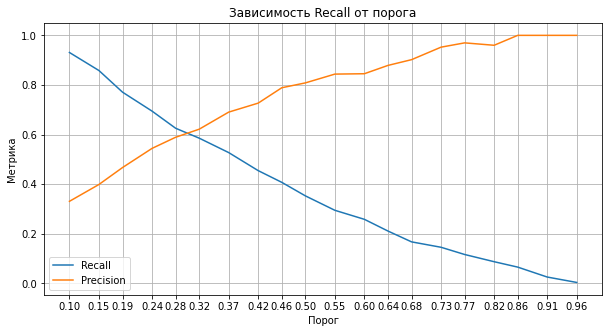

In [106]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(x=metrics['threshold'], y=metrics['recall'], label='Recall')
sns.lineplot(x=metrics['threshold'], y=metrics['precision'], label='Precision')
plt.xlabel('Порог')
plt.ylabel('Метрика')
plt.title('Зависимость Recall от порога')
plt.grid(True)
plt.xticks(thresholds)
plt.show()

Также мы проанализировали **вклад каждого признака в работу модели**, чтобы можно было обратить более пристальное внимание на признаки, обладающие большой важностью.

In [107]:
cat_search.best_estimator_.get_feature_importance(prettified=True)

,Feature Id,Importances
0,total_days,50.419492
1,type,12.571298
2,monthly_charges,9.317758
3,total_charges,7.111006
4,payment_method,5.065246
5,partner,3.741830
6,multiple_lines,3.121798
7,internet_service,2.977048
8,online_backup,1.902457
9,paperless_billing,1.348444


В процессе работы у меня возникли следующие **сложности**:
* Слабые корреляции входных признаков с целевым и сильные корреляций между входными признаками, а также тот факт, что распределение признаков не укладывается в нормальное, наложили на меня ограничение в использовании линейных моделей. Поэтому я воспользовалась моделями, не чувствительными к этим проблемам.
* Не получилось изучить важность признаков при помощи библиотеки shap из-за конфликта с типами данных. Эту проблему я решила, воспользовавшись future_importances.
* При расчёте Recall и Precision для разных порогов классификации функция выдавала противоречивые результаты. Поэтому я рассчитала значения метрик для разных порогов вручную.

Таким образом, были выполнены все пункты нашего плана и цель проекта была достигнута: наша модель предсказывает отток клиентов с необходимым уровнем качества.